In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#import paper_tools
import census
import numpy as np
#load the census data
#sheffield
#bbox = np.array([430,440,381,391])
bbox = np.array([433,437,382,386])
pathtodata = '/home/ubuntu/hetMOGPintegral/hetGPIntegralexperiments/'
shapefilename=pathtodata+'oaboundaries/Output_Area_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp'
oafilename=pathtodata+'oa_to_lsoa/OA11_LSOA11_MSOA11_LAD11_EW_LUv2.csv'
randomoafilename = pathtodata+'oa_to_lsoa/RANDOM_SOAS_2.csv' #this file contains MSOA that have been randomly assigned
oadescfilename=pathtodata+'oadata/KS102ew_2011_oa/KS102EW_2011STATH_NAT_OA_REL_1.4.4/KS102EWDESC0.CSV'
oadatafilename=pathtodata+'oadata/KS102ew_2011_oa/KS102EWDATA.CSV'

#X,Y,testX,testY = census.get_census_data(box=bbox*1000,verbose=True)
X1,Y1,oaX1,oaY1 = census.get_census_data(shapefilename=shapefilename,
                                         oafilename=oafilename,
                                         oadescfilename=oadescfilename,
                                         oadatafilename=oadatafilename,
                                         box=bbox*1000,verbose=True,refresh=False)
X1 = np.c_[X1,np.zeros([len(X1),1])]
oaX1 = np.c_[oaX1,np.zeros([len(oaX1),1])]

Trying cache...
Cache loaded.
Loaded from cache, 18 training polygons and 280 testing polygons


In [2]:
from shapeintegrals_fast_modified_for_hetGP import ShapeIntegral
import GPy
kern = GPy.kern.RBF(2, lengthscale=10.0, variance = 1.0, ARD=False)
oldshapek = ShapeIntegral(X1.shape[1],input_space_dim=2,Nperunit=5,kernel=kern)
m = GPy.models.GPRegression(X1,Y1,oldshapek)
m.Gaussian_noise=10.0
#predY,_=m.predict(testX)#[0:3,:]

 /home/mike/Documents/Research/hetMOGPintegral/hetGPIntegralexperiments/shapeintegrals_fast_modified_for_hetGP.py:93: RuntimeWarning:divide by zero encountered in true_divide


In [3]:
def oldplotsimplexes(X,c='k',lw=1):
    for x in X:
        edges = []
        if x[-1]==0:
            for tri in x[0:-1].reshape(int(len(x)/6),6):
                plt.plot(tri[[0,2,4,0]],tri[[1,3,5,1]],c=c,lw=lw)
        else:
            print("PLOTTING A POINT! AHH")
            plt.plot(x[0],x[1],'x'+c,mew=5,markersize=20)
            
            
def plotsimplexes(X,c='k',lw=1):
    for x in X:
        edges = []
        if x[-1]==0:
            for tri in x[0:-1].reshape(int(len(x)/6),6):
                edges.append(tri[[0,1,2,3]])
                edges.append(tri[[2,3,4,5]])
                edges.append(tri[[4,5,0,1]])
                
                
                plt.plot(tri[[0,2,4,0]],tri[[1,3,5,1]],c=c,lw=lw)
        else:
            plt.plot(x[0],x[1],'x'+c,mew=5,markersize=20)
            
            

            
#def plotsimplexes(X,c='k',lw=1):
#    for x in X:
#        if x[-1]==0:
#            for tri in x[0:-1].reshape(int(len(x)/6),6):
#                plt.plot(tri[[0,2,4,0]],tri[[1,3,5,1]],c=c,lw=lw)
#        else:
#            print("PLOTTING A POINT! AHH")
#            plt.plot(x[0],x[1],'x'+c,mew=5,markersize=20)
            
            


In [4]:
Xa,Xb = np.meshgrid(np.linspace(432,438,25),np.linspace(381,387,25))
testX = np.c_[Xa.flatten(),Xb.flatten()]
testX = np.c_[testX,np.ones([testX.shape[0],X1.shape[1]-2])]
#m.optimize()
#preds,_ = m.predict_noiseless(testX)

In [5]:
bbox

array([433, 437, 382, 386])

In [6]:
from dp4gp import datasets
from dp4gp import dp4gp
from dp4gp import histogram
from dp4gp.utils import dp_normalise, dp_unnormalise
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt
%matplotlib inline

#datasets.prepare_preloaded_prices('sheffield_houseprices.csv', col_list=[], since=2000, boundingbox=bbox[[0,2,1,3]]*1000, N=5000)
dataset = pd.read_csv('sheffield_houseprices.csv') #sheffield
#inputs = np.vstack([dataset['easting'].values,dataset['northing'].values]).T
#ys = dataset['price'].values

In [7]:
X2 = np.c_[dataset['easting'].values/1000,dataset['northing'].values/1000,np.full([len(dataset),X1.shape[1]-3],np.NaN),np.ones(len(dataset))]
tempY2 = dataset['type'].values
#plt.plot(east[dataset['type']==housetype].values/1000,north[dataset['type']==housetype].values/1000,pattern,markersize=2)

In [8]:
Y2 = np.zeros(len(tempY2))[:,None]
for i,t in enumerate(list(set(tempY2))):
    Y2[tempY2==t,0]=1.0*i

In [9]:
X = [X1,X2]
Y = [Y1,Y2]

# Analysis

In [10]:
import numpy as np
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm

import GPy
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg

# from likelihoods.bernoulli import Bernoulli
# from likelihoods.gaussian import Gaussian
# from likelihoods.categorical import Categorical
# from likelihoods.hetgaussian import HetGaussian
# from likelihoods.beta import Beta
# from likelihoods.gamma import Gamma
# from likelihoods.exponential import Exponential

# from hetmogp.util import draw_mini_slices
# from hetmogp.het_likelihood import HetLikelihood
# from hetmogp.model import HetMOGP
# from hetmogp import multi_output
# from hetmogp import util
# from hetmogp.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams
#from matplotlib2tikz import save as tikz_save

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import GPy
import matplotlib.pyplot as plt
from GPy.kern import Kern
from GPy.core.parameterization import Param
from paramz.transformations import Logexp
import math
from scipy.misc import factorial
import numpy as np
import math
import random
from shapeintegrals_fast_modified_for_hetGP import ShapeIntegral

In [11]:
latentkern = GPy.kern.RBF(2,lengthscale=10.0,variance=1.0)
k = ShapeIntegral(X1.shape[1],2,kernel=latentkern,Nperunit=3)
m = GPy.models.GPRegression(X1,Y1,k)
m.Gaussian_noise.fix(0.001)

 /home/mike/Documents/Research/hetMOGPintegral/hetGPIntegralexperiments/shapeintegrals_fast_modified_for_hetGP.py:93: RuntimeWarning:divide by zero encountered in true_divide


array([0])

In [12]:
m

GP_regression.,value,constraints,priors
shapeintegral.variance,1.0,+ve,
shapeintegral.lengthscale,1.0,+ve,
Gaussian_noise.variance,0.001,+ve fixed,


In [13]:
Xa,Xb = np.meshgrid(np.linspace(bbox[0],bbox[1],15),np.linspace(bbox[2],bbox[3],15))
testX = np.c_[Xa.flatten(),Xb.flatten()]
testX = np.c_[testX,np.ones([len(testX),X1.shape[1]-2])]
#preds,_ = m.predict_noiseless(testX)

In [14]:
set(dataset['type'])

{'D', 'F', 'O', 'S', 'T'}

In [15]:
Z = np.random.rand(40,X[0].shape[1])*4
Z[:,0]+=433 #[433,437,382,386])
Z[:,1]+=382
Z[:,2:-1]=np.NaN
Z[:,-1]=1
kern_list=[ShapeIntegral(X[0].shape[1],2,kernel=GPy.kern.RBF(2,lengthscale=1.0),Nperunit=2)]

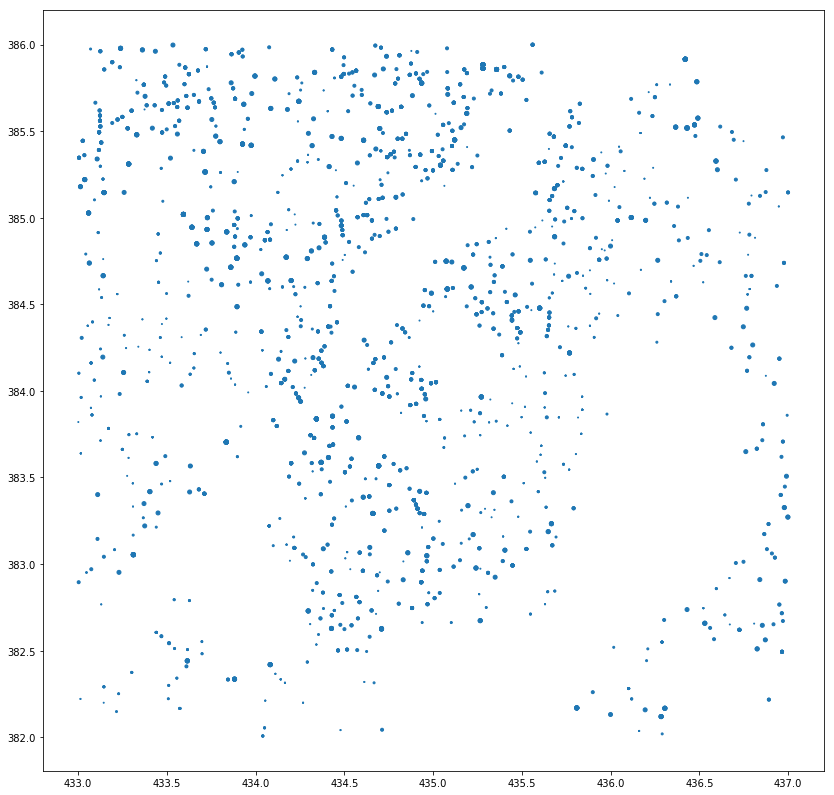

In [16]:
plt.figure(figsize=[14,14])
plt.scatter(X[1][:,0],X[1][:,1],Y[1][:,0]**2)

In [17]:
#X[0]=X[0][::1,:]
#Y[0]=Y[0][::1,:]
X[1]=X[1][::20,:]
Y[1]=Y[1][::20,:]

In [39]:
# MODEL and INFERENCE
Q=1
from HetMOGP.likelihoods.gaussian import Gaussian
from HetMOGP.likelihoods.categorical import Categorical
from HetMOGP.het_likelihood import HetLikelihood
from HetMOGP import util
from HetMOGP.svmogp import SVMOGP

#likelihoods_list = [Gaussian(sigma=0.001),Bernoulli(gp_link=GPy.likelihoods.link_functions.Probit())]#,Gaussian(sigma=1.0)]
likelihoods_list = [Gaussian(sigma=10), Categorical(5)]
likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()

D = likelihood.num_output_functions(Y_metadata)

W_list, _ = util.random_W_kappas(Q, D, rank=1, experiment=True)


model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata,batch_size=50)

 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


In [40]:
model.kern_list[0].variance = 100.0

In [41]:
X[1].shape

(250, 2929)

In [42]:
model.kern_list[0].variance.fix(100)
model.kern_list[0].lengthscale.fix(10)

array([0])

In [ ]:
from HetMOGP.util import vem_algorithm as VEM
model=VEM(model,vem_iters=6,maxIter_perVEM=4,optZ=False,verbose=True,verbose_plot=False,non_chained=True)

 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


iteration (1) VE step, mini-batch log_likelihood=[-3017789.18113832]
iteration (1) VM step, mini-batch log_likelihood=[-3017663.00225599]
iteration (2) VE step, mini-batch log_likelihood=[-3000641.84408123]
iteration (2) VM step, mini-batch log_likelihood=[-3000522.93982061]
iteration (3) VE step, mini-batch log_likelihood=[-2986271.73239119]
iteration (3) VM step, mini-batch log_likelihood=[-2986158.38666857]
iteration (4) VE step, mini-batch log_likelihood=[-2973879.26998077]
iteration (4) VM step, mini-batch log_likelihood=[-2973771.22846911]
iteration (5) VE step, mini-batch log_likelihood=[-2963046.80796443]


In [ ]:
model

In [ ]:
print(model)

In [ ]:
preds,_ = model.predictive_f_star(testX)

In [ ]:
preds

In [ ]:
plt.figure(figsize=[20,20])
ax=plt.gca()
plt.contourf(Xa, Xb, preds.reshape(Xa.shape[0],Xa.shape[1]))
plt.colorbar()
def plotsimplexes(X,Y,c,lw=1):
    for i,(x,y) in enumerate(zip(X,Y)):
        #plt.text(x[0],x[1],"%0.1f"%y)
        if x[-1]==0:
            for tri in x[0:-1].reshape(int(len(x)/6),6):
                plt.plot(tri[[0,2,4,0]],tri[[1,3,5,1]],c,lw=lw)
        else:
            plt.plot(x[0],x[1],['xr','ob','+g','.k','bx'][int(y[0])],mew=5,markersize=10)
plotsimplexes(X[1],Y[1],'g-')
plotsimplexes(X[0],Y[0],'g-')
plt.scatter(Z[:,0],Z[:,1])

for i in range(len(X[0])):
    v = m.kern.placepoints(X[0][i,:-1])[1]
    popden = (Y[0][i,0]/v)/10000
    if popden>1:
        popden=1
    c = np.array([popden,popden,popden,1])
    plt.scatter(X[0][i,0:-1:2],X[0][i,1::2],1,c=c[None,:])
plt.xlim([bbox[0],bbox[1]])
plt.ylim([bbox[2],bbox[3]])

In [ ]:
model.predictive(testX[0:1,:],output_function_ind=0)

In [ ]:
model.predictive(oaX1[0:1,:],output_function_ind=0)

In [ ]:
preds,_ = model.predictive(X1[0:1,:],output_function_ind=0)

In [ ]:
preds,_ = model.predictive(oaX1[0:4,:],output_function_ind=0)